<a href="https://colab.research.google.com/github/arnavsinghal09/GSoC-QMAML/blob/main/Quark_Gluon_Classification_MAML_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 1. Imports

import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import random
import matplotlib.pyplot as plt

In [3]:
# 2. Hyperparameters

DATA_DIR = "/content/drive/MyDrive/quark-gluon-dataset"
FILES = [
    "quark-gluon_train-set_n793900.hdf5",
    "quark-gluon_test-set_n139306.hdf5",
    "quark-gluon_test-set_n10000.hdf5"
]
FILE_PATHS = [f"{DATA_DIR}/{fname}" for fname in FILES]
FILE_LABELS = ["Train", "Test1", "Test2"]

BATCH_SIZE = 64
LEARNING_RATE = 1e-4
EPOCHS = 25
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SHAPE = (3, 125, 125)
N_WAY = 2
K_SHOT = 32
K_QUERY = 64
META_BATCH_SIZE = 8
INNER_STEPS = 10
INNER_LR = 0.02
NUM_WORKERS = 2
ADAPTATION_STEPS = 10

In [4]:
# 3. Dataset and Task Sampler

class JetImageDataset(Dataset):
    def __init__(self, X, y, pt=None, pt_bins=None):
        self.X = X
        self.y = y
        self.pt = pt
        self.pt_bins = pt_bins
        if self.pt is not None and self.pt_bins is not None:
            self.bin_indices = []
            for i in range(len(pt_bins) - 1):
                idx = np.where((pt >= pt_bins[i]) & (pt < pt_bins[i+1]))[0]
                self.bin_indices.append(idx)
        else:
            self.bin_indices = [np.arange(len(y))]
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = self.X[idx]
        if x.shape != IMG_SHAPE:
            x = np.transpose(x, (2, 0, 1))  # (3, 125, 125)
        label = int(self.y[idx])
        return torch.tensor(x, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

def sample_task(dataset, bin_idx, k_shot, k_query):
    idxs = dataset.bin_indices[bin_idx]
    idxs = np.random.permutation(idxs)
    support_idxs = idxs[:k_shot]
    query_idxs = idxs[k_shot:k_shot + k_query]
    X_s, y_s = zip(*[dataset[i] for i in support_idxs])
    X_q, y_q = zip(*[dataset[i] for i in query_idxs])
    return (torch.stack(X_s), torch.tensor(y_s)), (torch.stack(X_q), torch.tensor(y_q))

In [5]:
# 4. Model (Smaller CNN for MAML)

class JetCNN(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=2, padding=2), nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, n_classes)
        )
    def forward(self, x):
        return self.net(x)

In [6]:
# 5. Data Preparation and Meta-Task Definition

with h5py.File(FILE_PATHS[0], "r") as f:
    X = np.array(f["X_jets"][:100000])  # Use a manageable subset for Colab
    y = np.array(f["y"][:100000])
    pt = np.array(f["pt"][:100000])

pt_bins = np.percentile(pt, np.linspace(0, 100, 6))
print("pT bins:", pt_bins)

jet_dataset = JetImageDataset(X, y, pt=pt, pt_bins=pt_bins)

indices = np.arange(len(y))
np.random.shuffle(indices)
split = int(0.8 * len(indices))
train_idx, val_idx = indices[:split], indices[split:]
train_loader = DataLoader(
    Subset(jet_dataset, train_idx),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=NUM_WORKERS
)
val_loader = DataLoader(
    Subset(jet_dataset, val_idx),
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS
)

pT bins: [ 70.23306274  95.22527161 105.78971405 117.68426208 135.88970642
 323.42160034]


In [7]:
# 6. Training Loop for Classical Baseline

def compute_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return acc, f1, prec, rec

def train_baseline(model, train_loader, val_loader, epochs=EPOCHS):
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        y_true_train, y_pred_train = [], []
        for X, y in train_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits = model(X)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            preds = logits.argmax(dim=1)
            y_true_train.append(y)
            y_pred_train.append(preds)
        y_true_train = torch.cat(y_true_train)
        y_pred_train = torch.cat(y_pred_train)
        train_loss /= len(train_loader.dataset)
        train_acc, train_f1, train_prec, train_rec = compute_metrics(y_true_train, y_pred_train)

        # Validation
        model.eval()
        val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(DEVICE), y.to(DEVICE)
                logits = model(X)
                loss = loss_fn(logits, y)
                val_loss += loss.item() * X.size(0)
                preds = logits.argmax(dim=1)
                y_true_val.append(y)
                y_pred_val.append(preds)
        y_true_val = torch.cat(y_true_val)
        y_pred_val = torch.cat(y_pred_val)
        val_loss /= len(val_loader.dataset)
        val_acc, val_f1, val_prec, val_rec = compute_metrics(y_true_val, y_pred_val)

        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f} | "
              f"Prec: {train_prec:.4f} | Rec: {train_rec:.4f} || "
              f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f} | "
              f"Prec: {val_prec:.4f} | Rec: {val_rec:.4f}")
    return model

In [8]:
# 7. MAML Meta-Learning Loop

def forward_with_weights(x, weights):
    # Conv1
    x = nn.functional.conv2d(x, weights[0], weights[1], stride=2, padding=2)
    x = nn.functional.relu(x)
    # Conv2
    x = nn.functional.conv2d(x, weights[2], weights[3], stride=2, padding=1)
    x = nn.functional.relu(x)
    # Conv3
    x = nn.functional.conv2d(x, weights[4], weights[5], stride=2, padding=1)
    x = nn.functional.relu(x)
    # Conv4
    x = nn.functional.conv2d(x, weights[6], weights[7], stride=2, padding=1)
    x = nn.functional.relu(x)
    # Flatten
    x = x.view(x.size(0), -1)
    # FC1
    x = nn.functional.linear(x, weights[8], weights[9])
    x = nn.functional.relu(x)
    # FC2
    x = nn.functional.linear(x, weights[10], weights[11])
    return x

def maml_train(model, dataset, pt_bins, meta_batch_size=META_BATCH_SIZE, epochs=EPOCHS):
    model = model.to(DEVICE)
    meta_optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        meta_loss = 0
        all_y_true, all_y_pred = [], []
        for _ in range(meta_batch_size):
            bin_idx = random.randint(0, len(pt_bins)-2)
            (X_s, y_s), (X_q, y_q) = sample_task(dataset, bin_idx, K_SHOT, K_QUERY)
            X_s, y_s, X_q, y_q = X_s.to(DEVICE), y_s.to(DEVICE), X_q.to(DEVICE), y_q.to(DEVICE)
            fast_weights = [p.clone().detach().requires_grad_(True) for p in model.parameters()]
            for _ in range(INNER_STEPS):
                logits = forward_with_weights(X_s, fast_weights)
                loss = loss_fn(logits, y_s)
                grads = torch.autograd.grad(loss, fast_weights, create_graph=True)
                fast_weights = [w - INNER_LR * g for w, g in zip(fast_weights, grads)]
            logits_q = forward_with_weights(X_q, fast_weights)
            loss_q = loss_fn(logits_q, y_q)
            meta_loss += loss_q
            preds = logits_q.argmax(dim=1)
            all_y_true.append(y_q)
            all_y_pred.append(preds)
        meta_optimizer.zero_grad()
        meta_loss.backward()
        meta_optimizer.step()
        all_y_true = torch.cat(all_y_true)
        all_y_pred = torch.cat(all_y_pred)
        acc, f1, prec, rec = compute_metrics(all_y_true, all_y_pred)
        print(f"Epoch {epoch+1:2d} | Meta Loss: {meta_loss.item()/meta_batch_size:.4f} | "
              f"Acc: {acc:.4f} | F1: {f1:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")
    return model

In [9]:
# 8. Train and Evaluate Baseline

baseline_model = JetCNN()
baseline_model = train_baseline(baseline_model, train_loader, val_loader)

Epoch  1 | Train Loss: 0.6828 | Acc: 0.5357 | F1: 0.5596 | Prec: 0.5309 | Rec: 0.5917 || Val Loss: 0.6198 | Acc: 0.6826 | F1: 0.6833 | Prec: 0.6868 | Rec: 0.6798
Epoch  2 | Train Loss: 0.6047 | Acc: 0.6858 | F1: 0.6860 | Prec: 0.6836 | Rec: 0.6885 || Val Loss: 0.5951 | Acc: 0.6931 | F1: 0.7028 | Prec: 0.6859 | Rec: 0.7206
Epoch  3 | Train Loss: 0.5956 | Acc: 0.6905 | F1: 0.6969 | Prec: 0.6810 | Rec: 0.7135 || Val Loss: 0.5951 | Acc: 0.6927 | F1: 0.7177 | Prec: 0.6677 | Rec: 0.7758
Epoch  4 | Train Loss: 0.5940 | Acc: 0.6920 | F1: 0.7010 | Prec: 0.6794 | Rec: 0.7241 || Val Loss: 0.5925 | Acc: 0.6972 | F1: 0.7075 | Prec: 0.6886 | Rec: 0.7275
Epoch  5 | Train Loss: 0.5921 | Acc: 0.6939 | F1: 0.7011 | Prec: 0.6832 | Rec: 0.7200 || Val Loss: 0.5891 | Acc: 0.6999 | F1: 0.7137 | Prec: 0.6869 | Rec: 0.7426
Epoch  6 | Train Loss: 0.5870 | Acc: 0.6974 | F1: 0.7036 | Prec: 0.6877 | Rec: 0.7203 || Val Loss: 0.5804 | Acc: 0.7056 | F1: 0.7111 | Prec: 0.7028 | Rec: 0.7196
Epoch  7 | Train Loss: 0.574

In [10]:
# 9. Train and Evaluate MAML

maml_model = JetCNN()
maml_model = maml_train(maml_model, jet_dataset, pt_bins)

Epoch  1 | Meta Loss: 0.6953 | Acc: 0.4844 | F1: 0.2096 | Prec: 0.5469 | Rec: 0.1296
Epoch  2 | Meta Loss: 0.6945 | Acc: 0.4727 | F1: 0.3112 | Prec: 0.4766 | Rec: 0.2311
Epoch  3 | Meta Loss: 0.6956 | Acc: 0.4805 | F1: 0.4062 | Prec: 0.4740 | Rec: 0.3555
Epoch  4 | Meta Loss: 0.6916 | Acc: 0.5547 | F1: 0.3904 | Prec: 0.5703 | Rec: 0.2967
Epoch  5 | Meta Loss: 0.6935 | Acc: 0.4824 | F1: 0.1945 | Prec: 0.5000 | Rec: 0.1208


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch  6 | Meta Loss: 0.6929 | Acc: 0.5078 | F1: 0.0000 | Prec: 0.0000 | Rec: 0.0000
Epoch  7 | Meta Loss: 0.6880 | Acc: 0.5430 | F1: 0.3641 | Prec: 0.5234 | Rec: 0.2792


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch  8 | Meta Loss: 0.6949 | Acc: 0.4961 | F1: 0.0000 | Prec: 0.0000 | Rec: 0.0000
Epoch  9 | Meta Loss: 0.6901 | Acc: 0.5156 | F1: 0.4038 | Prec: 0.4375 | Rec: 0.3750
Epoch 10 | Meta Loss: 0.6892 | Acc: 0.5605 | F1: 0.3662 | Prec: 0.5078 | Rec: 0.2863


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 11 | Meta Loss: 0.6941 | Acc: 0.4863 | F1: 0.0000 | Prec: 0.0000 | Rec: 0.0000
Epoch 12 | Meta Loss: 0.6910 | Acc: 0.5273 | F1: 0.3495 | Prec: 0.5078 | Rec: 0.2664
Epoch 13 | Meta Loss: 0.6928 | Acc: 0.5059 | F1: 0.2263 | Prec: 0.5781 | Rec: 0.1407
Epoch 14 | Meta Loss: 0.6936 | Acc: 0.5000 | F1: 0.5096 | Prec: 0.5195 | Rec: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 15 | Meta Loss: 0.6948 | Acc: 0.4961 | F1: 0.0000 | Prec: 0.0000 | Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 16 | Meta Loss: 0.6924 | Acc: 0.5039 | F1: 0.0000 | Prec: 0.0000 | Rec: 0.0000
Epoch 17 | Meta Loss: 0.6879 | Acc: 0.5469 | F1: 0.3763 | Prec: 0.5469 | Rec: 0.2869


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 18 | Meta Loss: 0.6934 | Acc: 0.4941 | F1: 0.0000 | Prec: 0.0000 | Rec: 0.0000
Epoch 19 | Meta Loss: 0.6941 | Acc: 0.4863 | F1: 0.1858 | Prec: 0.4688 | Rec: 0.1158
Epoch 20 | Meta Loss: 0.6869 | Acc: 0.5664 | F1: 0.5356 | Prec: 0.5000 | Rec: 0.5766
Epoch 21 | Meta Loss: 0.6895 | Acc: 0.5762 | F1: 0.3887 | Prec: 0.5391 | Rec: 0.3040
Epoch 22 | Meta Loss: 0.6915 | Acc: 0.5234 | F1: 0.4404 | Prec: 0.5000 | Rec: 0.3934
Epoch 23 | Meta Loss: 0.6935 | Acc: 0.4941 | F1: 0.3443 | Prec: 0.5312 | Rec: 0.2547
Epoch 24 | Meta Loss: 0.6970 | Acc: 0.4824 | F1: 0.2090 | Prec: 0.5469 | Rec: 0.1292
Epoch 25 | Meta Loss: 0.6921 | Acc: 0.5176 | F1: 0.3778 | Prec: 0.5859 | Rec: 0.2788


In [11]:
# 10. Few-Shot Evaluation Function

def few_shot_eval(model, dataset, pt_bins, n_tasks=None, k_shot=K_SHOT, k_query=K_QUERY, inner_steps=INNER_STEPS, inner_lr=INNER_LR):
    model.eval()
    all_acc, all_f1, all_prec, all_rec = [], [], [], []
    n_bins = len(pt_bins) - 1 if n_tasks is None else n_tasks
    for bin_idx in range(n_bins):
        (X_s, y_s), (X_q, y_q) = sample_task(dataset, bin_idx, k_shot, k_query)
        X_s, y_s, X_q, y_q = X_s.to(DEVICE), y_s.to(DEVICE), X_q.to(DEVICE), y_q.to(DEVICE)
        # Fast adaptation (inner loop)
        fast_weights = [p.clone().detach().requires_grad_(True) for p in model.parameters()]
        loss_fn = nn.CrossEntropyLoss()
        for _ in range(inner_steps):
            logits = model(X_s)
            loss = loss_fn(logits, y_s)
            grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
            fast_weights = [w - inner_lr * g for w, g in zip(fast_weights, grads)]
        # Evaluate on query set
        def forward_with_weights(x, weights):
            # Conv1
            x = nn.functional.conv2d(x, weights[0], weights[1], stride=2, padding=2)
            x = nn.functional.relu(x)
            # Conv2
            x = nn.functional.conv2d(x, weights[2], weights[3], stride=2, padding=1)
            x = nn.functional.relu(x)
            # Conv3
            x = nn.functional.conv2d(x, weights[4], weights[5], stride=2, padding=1)
            x = nn.functional.relu(x)
            # Conv4
            x = nn.functional.conv2d(x, weights[6], weights[7], stride=2, padding=1)
            x = nn.functional.relu(x)
            # Flatten
            x = x.view(x.size(0), -1)
            # FC1
            x = nn.functional.linear(x, weights[8], weights[9])
            x = nn.functional.relu(x)
            # FC2
            x = nn.functional.linear(x, weights[10], weights[11])
            return x
        logits_q = forward_with_weights(X_q, fast_weights)
        preds = logits_q.argmax(dim=1)
        acc = accuracy_score(y_q.cpu().numpy(), preds.cpu().numpy())
        f1 = f1_score(y_q.cpu().numpy(), preds.cpu().numpy())
        prec = precision_score(y_q.cpu().numpy(), preds.cpu().numpy())
        rec = recall_score(y_q.cpu().numpy(), preds.cpu().numpy())
        all_acc.append(acc)
        all_f1.append(f1)
        all_prec.append(prec)
        all_rec.append(rec)
        print(f"Bin {bin_idx}: Acc={acc:.4f} | F1={f1:.4f} | Prec={prec:.4f} | Rec={rec:.4f}")
    print(f"\nMean Few-Shot: Acc={np.mean(all_acc):.4f} | F1={np.mean(all_f1):.4f} | Prec={np.mean(all_prec):.4f} | Rec={np.mean(all_rec):.4f}")
    return all_acc, all_f1, all_prec, all_rec

In [12]:
# 11. Few-Shot Evaluation for MAML and Baseline

print("MAML Few-Shot Evaluation:")
few_shot_eval(maml_model, jet_dataset, pt_bins)

print("\nClassical Baseline Few-Shot Evaluation (no adaptation):")
# For baseline, skip adaptation: just forward pass
def baseline_few_shot_eval(model, dataset, pt_bins, n_tasks=None, k_query=K_QUERY):
    model.eval()
    all_acc, all_f1, all_prec, all_rec = [], [], [], []
    n_bins = len(pt_bins) - 1 if n_tasks is None else n_tasks
    for bin_idx in range(n_bins):
        idxs = dataset.bin_indices[bin_idx]
        idxs = np.random.permutation(idxs)
        query_idxs = idxs[:k_query]
        X_q, y_q = zip(*[dataset[i] for i in query_idxs])
        X_q = torch.stack(X_q).to(DEVICE)
        y_q = torch.tensor(y_q).to(DEVICE)
        with torch.no_grad():
            logits_q = model(X_q)
            preds = logits_q.argmax(dim=1)
        acc = accuracy_score(y_q.cpu().numpy(), preds.cpu().numpy())
        f1 = f1_score(y_q.cpu().numpy(), preds.cpu().numpy())
        prec = precision_score(y_q.cpu().numpy(), preds.cpu().numpy())
        rec = recall_score(y_q.cpu().numpy(), preds.cpu().numpy())
        all_acc.append(acc)
        all_f1.append(f1)
        all_prec.append(prec)
        all_rec.append(rec)
        print(f"Bin {bin_idx}: Acc={acc:.4f} | F1={f1:.4f} | Prec={prec:.4f} | Rec={rec:.4f}")
    print(f"\nMean Few-Shot: Acc={np.mean(all_acc):.4f} | F1={np.mean(all_f1):.4f} | Prec={np.mean(all_prec):.4f} | Rec={np.mean(all_rec):.4f}")
    return all_acc, all_f1, all_prec, all_rec

baseline_few_shot_eval(baseline_model, jet_dataset, pt_bins)

MAML Few-Shot Evaluation:
Bin 0: Acc=0.5312 | F1=0.0000 | Prec=0.0000 | Rec=0.0000
Bin 1: Acc=0.5469 | F1=0.7071 | Prec=0.5469 | Rec=1.0000
Bin 2: Acc=0.5000 | F1=0.6667 | Prec=0.5000 | Rec=1.0000
Bin 3: Acc=0.5781 | F1=0.7327 | Prec=0.5781 | Rec=1.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Bin 4: Acc=0.5000 | F1=0.6667 | Prec=0.5000 | Rec=1.0000

Mean Few-Shot: Acc=0.5312 | F1=0.5546 | Prec=0.4250 | Rec=0.8000

Classical Baseline Few-Shot Evaluation (no adaptation):
Bin 0: Acc=0.6875 | F1=0.6154 | Prec=0.6667 | Rec=0.5714
Bin 1: Acc=0.8125 | F1=0.8182 | Prec=0.7941 | Rec=0.8438
Bin 2: Acc=0.7969 | F1=0.7869 | Prec=0.7742 | Rec=0.8000
Bin 3: Acc=0.7500 | F1=0.7647 | Prec=0.7647 | Rec=0.7647
Bin 4: Acc=0.7500 | F1=0.7419 | Prec=0.6389 | Rec=0.8846

Mean Few-Shot: Acc=0.7594 | F1=0.7454 | Prec=0.7277 | Rec=0.7729


([0.6875, 0.8125, 0.796875, 0.75, 0.75],
 [0.6153846153846154,
  0.8181818181818182,
  0.7868852459016393,
  0.7647058823529411,
  0.7419354838709677],
 [0.6666666666666666,
  0.7941176470588235,
  0.7741935483870968,
  0.7647058823529411,
  0.6388888888888888],
 [0.5714285714285714, 0.84375, 0.8, 0.7647058823529411, 0.8846153846153846])

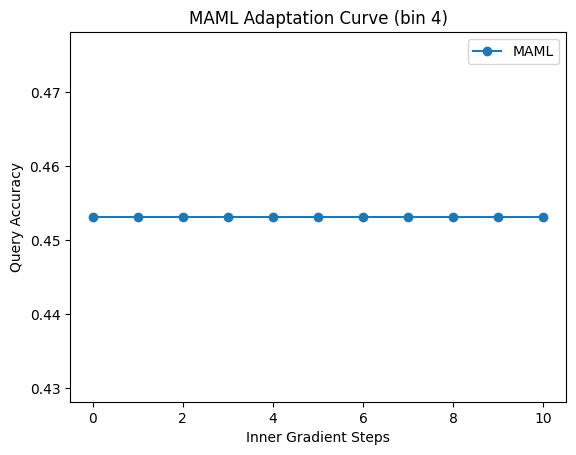

In [13]:
# Adaptation Curve Evaluation

def adaptation_curve(model, dataset, bin_idx, max_steps=ADAPTATION_STEPS, inner_lr=INNER_LR):
    (X_s, y_s), (X_q, y_q) = sample_task(dataset, bin_idx, K_SHOT, K_QUERY)
    X_s, y_s, X_q, y_q = X_s.to(DEVICE), y_s.to(DEVICE), X_q.to(DEVICE), y_q.to(DEVICE)
    fast_weights = [p.clone().detach().requires_grad_(True) for p in model.parameters()]
    loss_fn = nn.CrossEntropyLoss()
    accs = []
    for step in range(max_steps+1):
        logits_q = forward_with_weights(X_q, fast_weights)
        preds = logits_q.argmax(dim=1)
        acc = accuracy_score(y_q.cpu().numpy(), preds.cpu().numpy())
        accs.append(acc)
        if step < max_steps:
            logits_s = forward_with_weights(X_s, fast_weights)
            loss = loss_fn(logits_s, y_s)
            grads = torch.autograd.grad(loss, fast_weights, create_graph=True)
            fast_weights = [w - inner_lr * g for w, g in zip(fast_weights, grads)]
    return accs

# Plot adaptation curve for a random bin
bin_idx = random.randint(0, len(pt_bins)-2)
maml_accs = adaptation_curve(maml_model, jet_dataset, bin_idx)
plt.plot(range(len(maml_accs)), maml_accs, marker='o', label="MAML")
plt.xlabel("Inner Gradient Steps")
plt.ylabel("Query Accuracy")
plt.title(f"MAML Adaptation Curve (bin {bin_idx})")
plt.legend()
plt.show()

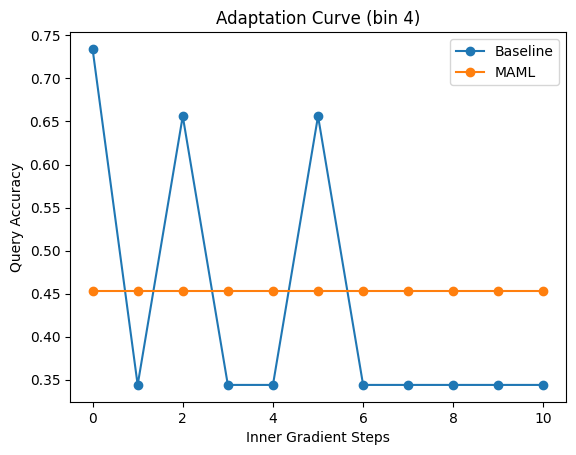

In [14]:
# Baseline Adaptation Curve (for comparison)

def baseline_adaptation_curve(model, dataset, bin_idx, max_steps=ADAPTATION_STEPS, inner_lr=INNER_LR):
    (X_s, y_s), (X_q, y_q) = sample_task(dataset, bin_idx, K_SHOT, K_QUERY)
    X_s, y_s, X_q, y_q = X_s.to(DEVICE), y_s.to(DEVICE), X_q.to(DEVICE), y_q.to(DEVICE)
    # Start from baseline weights (no meta-learning)
    fast_weights = [p.clone().detach().requires_grad_(True) for p in model.parameters()]
    loss_fn = nn.CrossEntropyLoss()
    accs = []
    for step in range(max_steps+1):
        logits_q = forward_with_weights(X_q, fast_weights)
        preds = logits_q.argmax(dim=1)
        acc = accuracy_score(y_q.cpu().numpy(), preds.cpu().numpy())
        accs.append(acc)
        if step < max_steps:
            logits_s = forward_with_weights(X_s, fast_weights)
            loss = loss_fn(logits_s, y_s)
            grads = torch.autograd.grad(loss, fast_weights, create_graph=True)
            fast_weights = [w - inner_lr * g for w, g in zip(fast_weights, grads)]
    return accs

baseline_accs = baseline_adaptation_curve(baseline_model, jet_dataset, bin_idx)
plt.plot(range(len(baseline_accs)), baseline_accs, marker='o', label="Baseline")
plt.plot(range(len(maml_accs)), maml_accs, marker='o', label="MAML")
plt.xlabel("Inner Gradient Steps")
plt.ylabel("Query Accuracy")
plt.title(f"Adaptation Curve (bin {bin_idx})")
plt.legend()
plt.show()